# NYC Taxi Project

### Version 1 - Excluding TRIP TIME as an input Feature

## Package Imports
- Below, I import some packages useful for the modelling and analysis of the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.linear_model import LinearRegression as LR, RidgeCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor as GBR
from lightgbm import LGBMRegressor as LGBM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import RandomForestRegressor as RF

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

## Reading Data
- The New York taxi data are given in two csv files: the fare data, and some other trip data. Thus, I will read them separately and then merge them on the common keys.

- First, I read the taxi trip fare data, and sample about 20,000 samples

In [2]:
trip_fare = pd.read_csv("trip_fare.csv").sample(n=20000, random_state = 42)
trip_fare.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
3242756,782B8A6E74DE10CD62CECCBE84D5CAB4,92A67EA859D8B5B14F8038D3187EA96A,CMT,1,N,2013-01-09 08:21:23,2013-01-09 08:34:45,1,801,1.60,-73.972404,40.756287,-73.982529,40.768150
10017129,3718399B3A00B1972CCB750194E8178E,F41119988409D1A070A770C0E60C511D,VTS,1,NaN,2013-01-28 21:49:00,2013-01-28 21:54:00,1,300,0.96,-74.004219,40.721130,-73.992371,40.723980
10176869,E6B521B1B859E2332125397D6CB6567E,0D07BABEBD0EC3F93E9A9F196153C49A,VTS,1,NaN,2013-01-29 17:05:00,2013-01-29 17:18:00,5,780,2.12,-73.994164,40.725506,-74.005630,40.717468
7357102,15E0847ED3276640BB4EA6ACB2417F8D,7C20CB6FA6E0BE121CF17019C7B9FAED,CMT,1,N,2013-01-15 16:02:13,2013-01-15 16:04:07,1,113,0.50,-73.960472,40.761589,-73.954750,40.769482
2164676,DCA1666E38B3AF4278E38531A3CAEBD9,006FAD57CE21BB431C86C2845150765E,VTS,1,NaN,2013-01-06 18:35:00,2013-01-06 18:54:00,2,1140,5.45,-73.971252,40.750980,-73.961349,40.711475


In [3]:
trip_fare.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude'],
      dtype='object')

In [4]:
trip_data = pd.read_csv("trip_data.csv").sample(n=20000, random_state = 42)
trip_data.head()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
3242756,782B8A6E74DE10CD62CECCBE84D5CAB4,92A67EA859D8B5B14F8038D3187EA96A,CMT,2013-01-09 08:21:23,CRD,10.0,0.0,0.5,2.62,0.0,13.12
10017129,3718399B3A00B1972CCB750194E8178E,F41119988409D1A070A770C0E60C511D,VTS,2013-01-28 21:49:00,CRD,6.0,0.5,0.5,1.30,0.0,8.30
10176869,E6B521B1B859E2332125397D6CB6567E,0D07BABEBD0EC3F93E9A9F196153C49A,VTS,2013-01-29 17:05:00,CRD,10.5,1.0,0.5,2.30,0.0,14.30
7357102,15E0847ED3276640BB4EA6ACB2417F8D,7C20CB6FA6E0BE121CF17019C7B9FAED,CMT,2013-01-15 16:02:13,CSH,4.0,1.0,0.5,0.00,0.0,5.50
2164676,DCA1666E38B3AF4278E38531A3CAEBD9,006FAD57CE21BB431C86C2845150765E,VTS,2013-01-06 18:35:00,CSH,19.5,0.0,0.5,0.00,0.0,20.00


In [5]:
trip_data.columns

Index(['medallion', ' hack_license', ' vendor_id', ' pickup_datetime',
       ' payment_type', ' fare_amount', ' surcharge', ' mta_tax',
       ' tip_amount', ' tolls_amount', ' total_amount'],
      dtype='object')

### Merging Dataframes
- From the two csv files, I identify the following as join keys:
 - pickup_datetime
 - hack_license

In [6]:
joint_data = trip_data.merge(trip_fare, how='inner', left_on=[' pickup_datetime',' hack_license' ], \
                  right_on=['pickup_datetime','hack_license' ]).sample(n=15000, random_state = 42)
print(joint_data.shape)
joint_data.head()

(15000, 25)


,medallion_x,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,...,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
10650,FA189EABBB4058AC0359AA1CF30F5313,428A8FDE9E3589FF0F7E83138260C5F7,CMT,2013-01-22 16:33:19,CRD,7.5,1.0,0.5,1.0,0.0,...,N,2013-01-22 16:33:19,2013-01-22 16:40:49,1,450,1.40,-73.987953,40.755711,-73.971672,40.756496
2041,42B6719514A5414A6E6A97AB6D17B8F6,0D99DF8A1493B1E7323F48BBF4B57ED7,CMT,2013-01-28 14:03:59,CSH,11.0,0.0,0.5,0.0,0.0,...,N,2013-01-28 14:03:59,2013-01-28 14:20:01,2,962,1.40,-73.991287,40.750523,-73.971931,40.745800
8668,3EF83F86FAC8B6E66644801410007800,5B32D25352C130E307A38AEC60BB1694,VTS,2013-01-27 11:37:00,CRD,5.5,0.0,0.5,1.0,0.0,...,NaN,2013-01-27 11:37:00,2013-01-27 11:41:00,1,240,0.97,0.000000,0.000000,0.000000,0.000000
1114,3932F94A3EEC2B46F8F3BEF17CF0FE6C,5B34A2589D1D2106FC0C47564A4833F0,CMT,2013-01-18 14:00:49,CSH,5.0,0.0,0.5,0.0,0.0,...,N,2013-01-18 14:00:49,2013-01-18 14:04:44,1,235,0.80,-73.957596,40.773727,-73.954742,40.783173
13902,C7BF056F5E2EF6D4CCF68EA4A23502A7,31C1767F1B1A285992705288B9024DD9,CMT,2013-01-21 17:19:46,CRD,7.0,0.0,0.5,1.5,0.0,...,N,2013-01-21 17:19:46,2013-01-21 17:27:25,1,458,1.10,-73.946274,40.750134,-73.946274,40.750134


In [7]:
joint_data.columns

Index(['medallion_x', ' hack_license', ' vendor_id', ' pickup_datetime',
       ' payment_type', ' fare_amount', ' surcharge', ' mta_tax',
       ' tip_amount', ' tolls_amount', ' total_amount', 'medallion_y',
       'hack_license', 'vendor_id', 'rate_code', 'store_and_fwd_flag',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_time_in_secs', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'],
      dtype='object')

## Extracting input features (X)
- Next, I extract relevant input features by dropping the target variable, duplicate features, or features not relevant or containing too many null values for the prediction.

In [8]:
X = joint_data.drop(columns = ['medallion_x', ' hack_license', 'store_and_fwd_flag','medallion_y','hack_license', \
                          ' fare_amount', ' tip_amount',' total_amount',' pickup_datetime',' vendor_id', 'trip_time_in_secs'])
X.head()

,payment_type,surcharge,mta_tax,tolls_amount,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
10650,CRD,1.0,0.5,0.0,CMT,1,2013-01-22 16:33:19,2013-01-22 16:40:49,1,1.40,-73.987953,40.755711,-73.971672,40.756496
2041,CSH,0.0,0.5,0.0,CMT,1,2013-01-28 14:03:59,2013-01-28 14:20:01,2,1.40,-73.991287,40.750523,-73.971931,40.745800
8668,CRD,0.0,0.5,0.0,VTS,1,2013-01-27 11:37:00,2013-01-27 11:41:00,1,0.97,0.000000,0.000000,0.000000,0.000000
1114,CSH,0.0,0.5,0.0,CMT,1,2013-01-18 14:00:49,2013-01-18 14:04:44,1,0.80,-73.957596,40.773727,-73.954742,40.783173
13902,CRD,0.0,0.5,0.0,CMT,1,2013-01-21 17:19:46,2013-01-21 17:27:25,1,1.10,-73.946274,40.750134,-73.946274,40.750134


In [9]:
X.columns

Index([' payment_type', ' surcharge', ' mta_tax', ' tolls_amount', 'vendor_id',
       'rate_code', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude'],
      dtype='object')

## Feature Engineering
- Next, I engineer a few features from the existing set of features that are expected to correlate well with the target. For example, datetime features such as day of week may correlate well with the trip duration. Similarly, the direction of travel may be predictive of the trip duration.

- Extracting datetime features

In [10]:
X["pickup_datetime"] = pd.to_datetime(X["pickup_datetime"])
X['dropoff_datetime'] = pd.to_datetime(X['dropoff_datetime'])

X["pickup_month"] = X["pickup_datetime"].dt.month
X["pickup_hour"] = X["pickup_datetime"].dt.hour
X["pickup_minute"] = X["pickup_datetime"].dt.minute
X["pickup_dayofweek"] = X["pickup_datetime"].dt.dayofweek

X = X.drop(columns = ["dropoff_datetime","pickup_datetime"])
X.head()

,payment_type,surcharge,mta_tax,tolls_amount,vendor_id,rate_code,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_hour,pickup_minute,pickup_dayofweek
10650,CRD,1.0,0.5,0.0,CMT,1,1,1.40,-73.987953,40.755711,-73.971672,40.756496,1,16,33,1
2041,CSH,0.0,0.5,0.0,CMT,1,2,1.40,-73.991287,40.750523,-73.971931,40.745800,1,14,3,0
8668,CRD,0.0,0.5,0.0,VTS,1,1,0.97,0.000000,0.000000,0.000000,0.000000,1,11,37,6
1114,CSH,0.0,0.5,0.0,CMT,1,1,0.80,-73.957596,40.773727,-73.954742,40.783173,1,14,0,4
13902,CRD,0.0,0.5,0.0,CMT,1,1,1.10,-73.946274,40.750134,-73.946274,40.750134,1,17,19,0


- Extracting the trip direction into a new column

In [11]:
latitude_diff = X['dropoff_latitude'] - X['pickup_latitude']
longitude_diff = X['dropoff_longitude'] - X['pickup_longitude']
ratio = longitude_diff/latitude_diff
X['trip_direction'] = np.arctan(ratio)
X.loc[(latitude_diff == 0) & (longitude_diff > 0), 'trip_direction'] = np.pi/2
X.loc[(latitude_diff == 0) & (longitude_diff < 0), 'trip_direction'] = -np.pi/2
X.loc[(latitude_diff == 0) & (longitude_diff==0), 'trip_direction'] = 0
print(X.shape)
X.head()

(15000, 17)


,payment_type,surcharge,mta_tax,tolls_amount,vendor_id,rate_code,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_hour,pickup_minute,pickup_dayofweek,trip_direction
10650,CRD,1.0,0.5,0.0,CMT,1,1,1.40,-73.987953,40.755711,-73.971672,40.756496,1,16,33,1,1.522618
2041,CSH,0.0,0.5,0.0,CMT,1,2,1.40,-73.991287,40.750523,-73.971931,40.745800,1,14,3,0,-1.331466
8668,CRD,0.0,0.5,0.0,VTS,1,1,0.97,0.000000,0.000000,0.000000,0.000000,1,11,37,6,0.000000
1114,CSH,0.0,0.5,0.0,CMT,1,1,0.80,-73.957596,40.773727,-73.954742,40.783173,1,14,0,4,0.293418
13902,CRD,0.0,0.5,0.0,CMT,1,1,1.10,-73.946274,40.750134,-73.946274,40.750134,1,17,19,0,0.000000


- Converting categorical variables to dummy variables

In [12]:
X = pd.get_dummies(X, columns = [" payment_type", "vendor_id"], drop_first = True)
print(X.shape)
X.head()

(15000, 20)


,surcharge,mta_tax,tolls_amount,rate_code,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_hour,pickup_minute,pickup_dayofweek,trip_direction,payment_type_CSH,payment_type_DIS,payment_type_NOC,payment_type_UNK,vendor_id_VTS
10650,1.0,0.5,0.0,1,1,1.40,-73.987953,40.755711,-73.971672,40.756496,1,16,33,1,1.522618,0,0,0,0,0
2041,0.0,0.5,0.0,1,2,1.40,-73.991287,40.750523,-73.971931,40.745800,1,14,3,0,-1.331466,1,0,0,0,0
8668,0.0,0.5,0.0,1,1,0.97,0.000000,0.000000,0.000000,0.000000,1,11,37,6,0.000000,0,0,0,0,1
1114,0.0,0.5,0.0,1,1,0.80,-73.957596,40.773727,-73.954742,40.783173,1,14,0,4,0.293418,1,0,0,0,0
13902,0.0,0.5,0.0,1,1,1.10,-73.946274,40.750134,-73.946274,40.750134,1,17,19,0,0.000000,0,0,0,0,0


- Dropping features that have a constant value across all the rows

In [13]:
nunique = X.nunique()
cols_to_drop = nunique[nunique == 1].index
X = X.drop(cols_to_drop, axis=1)
print(X.shape)
X.head()

(15000, 19)


,surcharge,mta_tax,tolls_amount,rate_code,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour,pickup_minute,pickup_dayofweek,trip_direction,payment_type_CSH,payment_type_DIS,payment_type_NOC,payment_type_UNK,vendor_id_VTS
10650,1.0,0.5,0.0,1,1,1.40,-73.987953,40.755711,-73.971672,40.756496,16,33,1,1.522618,0,0,0,0,0
2041,0.0,0.5,0.0,1,2,1.40,-73.991287,40.750523,-73.971931,40.745800,14,3,0,-1.331466,1,0,0,0,0
8668,0.0,0.5,0.0,1,1,0.97,0.000000,0.000000,0.000000,0.000000,11,37,6,0.000000,0,0,0,0,1
1114,0.0,0.5,0.0,1,1,0.80,-73.957596,40.773727,-73.954742,40.783173,14,0,4,0.293418,1,0,0,0,0
13902,0.0,0.5,0.0,1,1,1.10,-73.946274,40.750134,-73.946274,40.750134,17,19,0,0.000000,0,0,0,0,0


## Extracting output features (y)

In [14]:
y = joint_data['trip_time_in_secs'].values

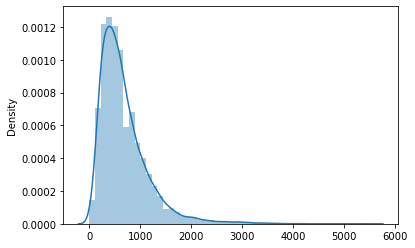

In [15]:
sns.distplot(y)
plt.show()

## Light Gradient Boosting Machine (LGBM)

In [16]:
import lightgbm as lgb
from lightgbm import LGBMRegressor as LGBM

### Hyperparameter search with 5-fold cross validation
- Being a boosted tree model, there are a number of hyperparameters that can be tuned to improve the performance. Here, I define a grid containing the following hyperparameters: learning_rate, n_estimators, max_depth, num_leaves. max_depth = -1 denotes there is no maximum.

In [17]:
model_LGBM = LGBM(random_state = 42)
distributions = {"learning_rate":[0.001, 0.01, 0.1], "n_estimators":[100, 500, 1000, 2000],\
                 "max_depth": [-1, 5, 10], "num_leaves":[21, 31, 41]}

search = GridSearchCV(model_LGBM, distributions, cv=5)
search_results = search.fit(X, y)
search_results.best_params_

{'learning_rate': 0.01,
 'max_depth': -1,
 'n_estimators': 2000,
 'num_leaves': 31}

{'learning_rate': 0.01,
 'max_depth': -1,
 'n_estimators': 2000,
 'num_leaves': 31}

### Model training
- I now use the optimal hyperparameters found to train an LGBM model and visualise the training and validation curves, as well as the feature importances. 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [19]:
model = LGBM(random_state = 42, learning_rate = 0.01,  n_estimators=2000, \
             max_depth = -1, num_leaves=31).fit(X_train, y_train, eval_metric='mse',\
               eval_set=[(X_test,y_test),(X_train,y_train)], verbose=False)
y_predicted = model.predict(X_test)
mse = MSE(y_test, y_predicted, squared=True)
rsquared = r2_score(y_test, y_predicted)
mse, rsquared

(59093.96571923402, 0.7708581072120986)

### Training and validation curves

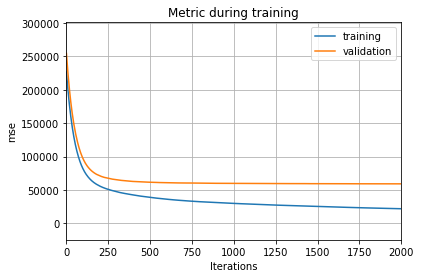

In [20]:
lgb.plot_metric(model)
plt.ylabel('mse')
plt.legend(['training','validation'])
plt.show()

### Feature importance
- Here, I visualise which of the features are the most important for the prediction of the trip duration.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

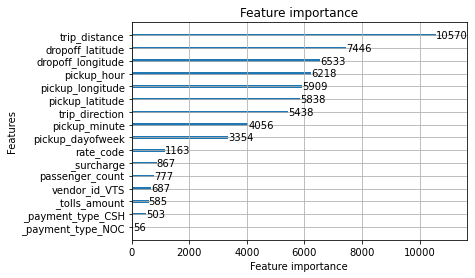

In [21]:
lgb.plot_importance(model)

## K-Fold Cross Validation

- In the K-Fold cross validation loop, I perform one main preprocessing step on each of the training folds, i.e., normalisation of the input features

- In each iteration, the performance of the LGBM model is compared with other models: Linear Regression (LR), Ridge regression, Lasso regression, K-Nearest Neighbours (KNN), Random Forest (RF) and a multilayer perceptron neural network (MLP).

In [22]:
KFold_cross_validation = KFold(n_splits=10, random_state=42, shuffle=True)
KFold_cross_validation.get_n_splits(X, y)

mse_list_LR, r2_list_LR, time_list_LR = [], [], []
mse_list_LGBM, r2_list_LGBM, time_list_LGBM = [], [], []
mse_list_KNN, r2_list_KNN, time_list_KNN = [], [], []
mse_list_MLP, r2_list_MLP, time_list_MLP = [], [], []
mse_list_RF, r2_list_RF, time_list_RF = [], [], []
mse_list_Lasso, r2_list_Lasso, time_list_Lasso = [], [], []
mse_list_Ridge, r2_list_Ridge, time_list_Ridge = [], [], []


counter = 0 
for train_index, test_index in KFold_cross_validation.split(X, y):
    counter = counter + 1
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    """Preprocessing"""
    # Normalisation with StandardScaler
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    """Model training"""

    #LGBM
    start_time = time.time()
    model_LGBM = LGBM(random_state = 42, learning_rate = 0.01,  n_estimators=2000, \
                     max_depth = -1, num_leaves=31).fit(X_train_scaled, y_train)
    time_LGBM = time.time() - start_time
    time_list_LGBM.append(time_LGBM)
    y_predicted_LGBM = model_LGBM.predict(X_test_scaled)
    mse_LGBM = MSE(y_test, y_predicted_LGBM, squared=True)
    mse_list_LGBM.append(mse_LGBM)
    rsquared_LGBM = r2_score(y_test, y_predicted_LGBM)
    r2_list_LGBM.append(rsquared_LGBM)
    
    #Linear regression
    start_time = time.time()
    model_LR = LR().fit(X_train_scaled, y_train)
    time_LR = time.time() - start_time
    time_list_LR.append(time_LR)
    y_predicted_LR = model_LR.predict(X_test_scaled)
    mse_LR = MSE(y_test, y_predicted_LR, squared=True)
    mse_list_LR.append(mse_LR)
    rsquared_LR = r2_score(y_test, y_predicted_LR)
    r2_list_LR.append(rsquared_LR)
    
    #Ridge regression
    start_time = time.time()
    model_Ridge = RidgeCV(alphas=(1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 100)).fit(X_train_scaled, y_train)
    time_Ridge = time.time() - start_time
    time_list_Ridge.append(time_Ridge)
    y_predicted_Ridge = model_Ridge.predict(X_test_scaled)
    mse_Ridge = MSE(y_test, y_predicted_Ridge, squared=True)
    mse_list_Ridge.append(mse_Ridge)
    rsquared_Ridge = r2_score(y_test, y_predicted_Ridge)
    r2_list_Ridge.append(rsquared_Ridge)
    
    #Lasso regression
    start_time = time.time()
    model_Lasso = LassoCV(n_alphas=100).fit(X_train_scaled, y_train)
    time_Lasso = time.time() - start_time
    time_list_Lasso.append(time_Lasso)
    y_predicted_Lasso = model_Lasso.predict(X_test_scaled)
    mse_Lasso = MSE(y_test, y_predicted_Lasso, squared=True)
    mse_list_Lasso.append(mse_Lasso)
    rsquared_Lasso = r2_score(y_test, y_predicted_Lasso)
    r2_list_Lasso.append(rsquared_Lasso)
    
    #K Nearest Neighbours
    start_time = time.time()
    model_KNN = KNN(n_neighbors=5, leaf_size=4).fit(X_train_scaled, y_train)
    time_KNN = time.time() - start_time
    time_list_KNN.append(time_KNN)
    y_predicted_KNN = model_KNN.predict(X_test_scaled)
    mse_KNN = MSE(y_test, y_predicted_KNN, squared=True)
    mse_list_KNN.append(mse_KNN)
    rsquared_KNN = r2_score(y_test, y_predicted_KNN)
    r2_list_KNN.append(rsquared_KNN)
    
    #Random Forest regression
    start_time = time.time()
    model_RF = RF(random_state=42).fit(X_train_scaled, y_train)
    time_RF = time.time() - start_time
    time_list_RF.append(time_RF)
    y_predicted_RF = model_RF.predict(X_test_scaled)
    mse_RF = MSE(y_test, y_predicted_RF, squared=True)
    mse_list_RF.append(mse_RF)
    rsquared_RF = r2_score(y_test, y_predicted_RF)
    r2_list_RF.append(rsquared_RF)
    
    #Neural Network: Multilayer Perceptron
    start_time = time.time()
    model = keras.Sequential([layers.Dense(100, activation = 'tanh', input_shape = [X_train_scaled.shape[1]]),
                         #layers.Dense(128, activation = 'tanh'), 
                         #layers.Dense(65, activation = 'tanh'),
                         #layers.Dropout(0.2),
                         layers.Dense(1)])
    model.compile(loss = 'mse', optimizer = keras.optimizers.SGD(), metrics = ['mse'])
    history = model.fit(X_train_scaled, y_train, validation_split = 0.2, epochs = 100, verbose =False)
    time_MLP = time.time() - start_time
    time_list_MLP.append(time_MLP)
    y_predicted_MLP = model.predict(X_test_scaled)
    mse_MLP = MSE(y_test, y_predicted_MLP, squared=True)
    mse_list_MLP.append(mse_MLP)
    rsquared_MLP = r2_score(y_test, y_predicted_MLP)
    r2_list_MLP.append(rsquared_MLP)
    
    
    print("Test fold: " , counter)
    print('LGBM: ', 'mse = '+str(mse_LGBM), ' r_squared = '+str(rsquared_LGBM), ' training time = '+str(time_LGBM))
    print('LR: ', 'mse = '+str(mse_LR), ' r_squared = '+str(rsquared_LR), ' training time = '+str(time_LR))
    print('Ridge: ', 'mse = '+str(mse_Ridge), ' r_squared = '+str(rsquared_Ridge), ' training time = '+str(time_Ridge))
    print('Lasso: ', 'mse = '+str(mse_Lasso), ' r_squared = '+str(rsquared_Lasso), ' training time = '+str(time_Lasso))
    print('KNN: ', 'mse = '+str(mse_KNN), ' r_squared = '+str(rsquared_KNN), ' training time = '+str(time_KNN))
    print('RF: ', 'mse = '+str(mse_RF), ' r_squared = '+str(rsquared_RF), ' training time = '+str(time_RF))
    print('MLP: ', 'mse = '+str(mse_MLP), ' r_squared = '+str(rsquared_MLP), ' training time = '+str(time_MLP))
    print('\n')
    
rmse_list_LR = np.sqrt(np.array(mse_list_LR))
rmse_list_LGBM = np.sqrt(np.array(mse_list_LGBM))
rmse_list_KNN = np.sqrt(np.array(mse_list_KNN))
rmse_list_MLP = np.sqrt(np.array(mse_list_MLP))
rmse_list_RF = np.sqrt(np.array(mse_list_RF))
rmse_list_Lasso = np.sqrt(np.array(mse_list_Lasso))
rmse_list_Ridge = np.sqrt(np.array(mse_list_Ridge))

Test fold:  1
LGBM:  mse = 48935.3052722409  r_squared = 0.8022966059430576  training time = 4.7732415199279785
LR:  mse = 83701.0200711388  r_squared = 0.6618397359119077  training time = 0.01713418960571289
Ridge:  mse = 83780.9222494331  r_squared = 0.661516923338175  training time = 0.03626108169555664
Lasso:  mse = 83735.89089716853  r_squared = 0.6616988543822782  training time = 0.35903143882751465
KNN:  mse = 99978.25992  r_squared = 0.5960781033626519  training time = 0.8546013832092285
RF:  mse = 53371.288469733336  r_squared = 0.7843748022627746  training time = 20.633132457733154
MLP:  mse = 77926.05577334845  r_squared = 0.6851711535025216  training time = 56.96157193183899


Test fold:  2
LGBM:  mse = 70492.93709681794  r_squared = 0.7372263412257061  training time = 4.676299571990967
LR:  mse = 109186.24888653486  r_squared = 0.5929908542702704  training time = 0.015623807907104492
Ridge:  mse = 108909.31718367242  r_squared = 0.5940231613323497  training time = 0.037389

## Boxplot of results

### MSE

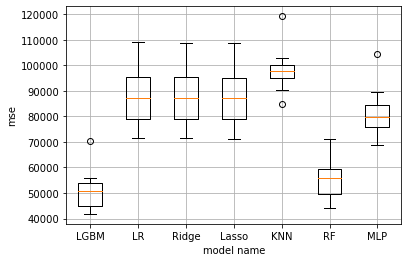

In [23]:
plt.boxplot([mse_list_LGBM, mse_list_LR, mse_list_Ridge, mse_list_Lasso, mse_list_KNN, mse_list_RF, mse_list_MLP],\
            labels = ['LGBM', 'LR','Ridge','Lasso', 'KNN', 'RF', 'MLP'])
plt.grid()
plt.xlabel("model name")
plt.ylabel("mse")
plt.show()

### RMSE

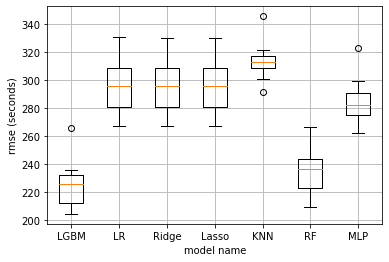

In [24]:
plt.boxplot([rmse_list_LGBM, rmse_list_LR, rmse_list_Ridge, rmse_list_Lasso, rmse_list_KNN, rmse_list_RF, rmse_list_MLP],\
            labels = ['LGBM', 'LR','Ridge','Lasso', 'KNN', 'RF', 'MLP'])
plt.grid()
plt.xlabel("model name")
plt.ylabel("rmse (seconds)")
plt.show()

### R squared

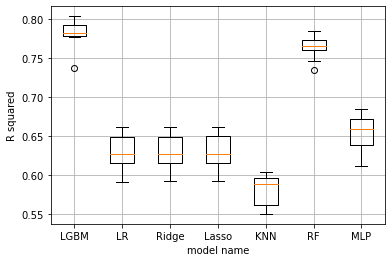

In [25]:
plt.boxplot([r2_list_LGBM, r2_list_LR, r2_list_Ridge, r2_list_Lasso, r2_list_KNN, r2_list_RF, r2_list_MLP],\
            labels = ['LGBM', 'LR','Ridge','Lasso', 'KNN', 'RF', 'MLP'])
plt.grid()
plt.xlabel("model name")
plt.ylabel("R squared")
plt.show()

### Training time

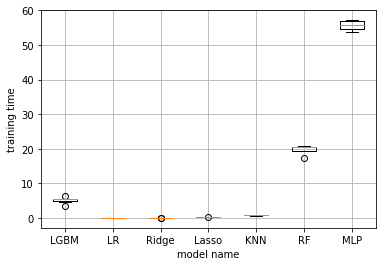

In [26]:
plt.boxplot([time_list_LGBM, time_list_LR, time_list_Ridge, time_list_Lasso, time_list_KNN, time_list_RF, time_list_MLP],\
            labels = ['LGBM', 'LR','Ridge','Lasso', 'KNN', 'RF', 'MLP'])
plt.grid()
plt.xlabel("model name")
plt.ylabel("training time")
plt.show()